AMAZON FINE FOOD REVIEWS ANALYSIS
Objective:
    
1.Get the vector representation for each of the reviews.For this , use
1)BoW 2)TfIdf 3)Avg W2V 4)TfIdf Weighted W2V

2. Use all the 4 methods and apply T-sneto get a plot such that every review
is represntated by a point and such that positive and negative reviews get
separated by a hyperplane.(supposedly)Assign positive reviews blue and negative
reviews red colour.
Compare them.Conclude.
Using 3k datapoints for computation.


Score 1: Used for positive reviews.
Score 0: Used for negative reviews.

In [1]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import numpy as np
import pandas as pd
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

C:\Users\shubh\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
#importing dataset using sqlite
con = sqlite3.connect(r'C:\Users\shubh\Desktop\amazon-fine-food-reviews\database.sqlite')

#using r before string to convert normal string into raw string.
#Cannot import dataset directly without using r. Or try '/' instead of '\'.
#filter positive and negative values.
#drop values of score=3

In [3]:
filtered_data = pd.read_sql_query("""
SELECT * FROM REVIEWS where Score!=3
""",con)

In [4]:
filtered_data.shape
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [5]:
#originally its contains 525814 reviews in total(excluding socer point of 3)
#change scores to 0 and 1
#using lambda function
filtered_data['Score']=filtered_data['Score'].map(lambda x:0 if x<3 else 1)

In [6]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [7]:
#Score values successfully changed
filtered_data['Score'].value_counts()

1    443777
0     82037
Name: Score, dtype: int64

In [8]:
#there are 443777 positive reviews and 82037 negative reviews.
#Deduplication
#Sorting by product id
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


In [9]:
#Entries deduplication
final = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep='first',inplace=False)
final.shape

(364173, 10)

In [10]:
#TOtal reviews reduced to 364173
#also given the helpfulness num< helpfullness denom
#HENCE
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape

(364171, 10)

In [11]:
#TOtal reviews reduced to 364173
final['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

307061 reviews are positive
57110 reviews are negative

Starting with preprocessing of Data

In [12]:
from nltk.corpus import stopwords
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned



Implementing the step-by step checks for stop word removal, html  removal,
alphanumeric, lowercase conversion,etc


In [13]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    for i, sent in enumerate(tqdm(final['Text'].values)):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            # we have used cleanpunc(w).split(), one more split function here because consider w="abc.def", cleanpunc(w) will return "abc def"
            # if we dont use .split() function then we will be considring "abc def" as a single word, but if you use .split() function we will get "abc", "def"
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 1: 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 0:
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")
        final_string.append(str1)

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [20:48<00:00, 291.77it/s]


Connect to final.sqlite

In [14]:
conn = sqlite3.connect('final.sqlite')


Using First method to convert words to vector: BoW

In [15]:
finalp = final[final.Score == 1]
finaln = final[final.Score == 0]
#Creating balanced dataset by equalising datapoints of positive and negative reviews.

In [16]:
datap = finalp.iloc[0:1500,:]
datan = finaln.iloc[0:1500,:]
datap.shape,datan.shape

((1500, 11), (1500, 11))

In [17]:
final_final = pd.concat([datap,datan],ignore_index=True)

In [18]:
final_final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

In [19]:
#final_final contains a balanced dataset of positive and negative reviews.

In [21]:
#BoW#Using bi_grams, since we know there important words like 'not' in the dataset.
count_vect = CountVectorizer(ngram_range=(1,2)) 
final_counts = count_vect.fit_transform(final_final['CleanedText'].values)


In [22]:
print("the shape of out text BOW vectorizer ",final_counts.shape)
print("the number of unique words are ", final_counts.get_shape()[1])

the shape of out text BOW vectorizer  (3000, 105115)
the number of unique words are  105115


Apply TSNE for BoW:

In [23]:
#taking first 3k datapoints
data = final_counts
score = final_final['Score'][0:3000]

In [24]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler(with_mean=False).fit_transform(data)

C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\shubh\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [25]:
standardized_data.shape
#standardised with mean=flase since it gives for sparse matrix wouldnt be sparse if standardised with mean=true

(3000, 105115)

In [26]:
std_data = standardized_data.todense()
std_data.shape

(3000, 105115)

In [27]:
#TSNE
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T,score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1","dim2","score"))


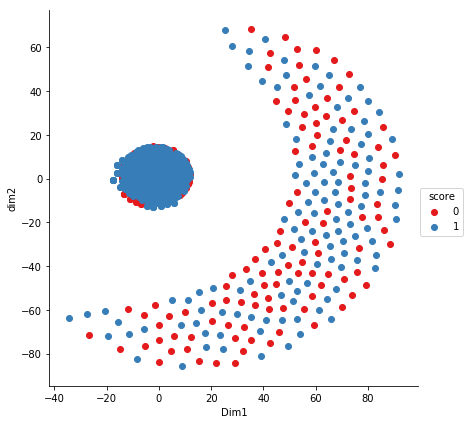

In [28]:
#result
sns.FacetGrid(tsne_df,hue="score",palette="Set1",hue_order=[0, 1],size=6).map(plt.scatter,'Dim1','dim2').add_legend()
plt.show()


Observations:
    As we can see, we cannot draw a hyperplane to separate the positive and the negative reviews.
    

TF_IDF

In [29]:
#Here too using bi-grams
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_final['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3000, 105115)
the number of unique words including both unigrams and bigrams  105115


Apply TSNE

In [30]:
std_data = StandardScaler(with_mean=False).fit_transform(final_tf_idf)

std_data= std_data.todense()
std_data.shape

(3000, 105115)

In [31]:
#Tfidf Data successfully standardised
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1","dim2","score"))


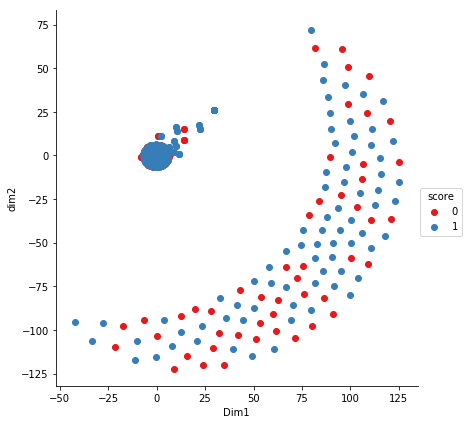

In [32]:
sns.FacetGrid(tsne_df,hue="score",palette="Set1",hue_order=[0, 1],size=6).map(plt.scatter,'Dim1','dim2').add_legend()
plt.show()

Observation: Here too, the shape is not feasible to draw a hyperplane in between. 

For W2V: Training own model.

    

In [33]:
i=0
list_of_sent=[]
for sent in final['CleanedText'].values:
    list_of_sent.append(sent.split())

In [34]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50,workers=4)

In [35]:
w2v_words = list(w2v_model.wv.vocab)

In [36]:
w2v_model.wv.most_similar('tasti')

[('delici', 0.8105766773223877),
 ('yummi', 0.7880966663360596),
 ('tastey', 0.7621139883995056),
 ('good', 0.6815287470817566),
 ('nice', 0.6814108490943909),
 ('satisfi', 0.6620628833770752),
 ('hearti', 0.6552608013153076),
 ('nutriti', 0.6348538398742676),
 ('great', 0.6285862922668457),
 ('terrif', 0.6238007545471191)]

In [37]:
#model trained successfully.
#avgw2v
i=0
list_of_sent=[]
for sent in final_final['CleanedText'].values:
    list_of_sent.append(sent.split())

    

In [38]:
#Avgw2v
sent_vectors = []
for sent in tqdm(list_of_sent):
    sent_vec = np.zeros(50)
    cnt_words=0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:06<00:00, 446.35it/s]


In [39]:
print(len(sent_vectors))
print(len(sent_vectors[0]))

3000
50


Applying TSNE on AVG W2V

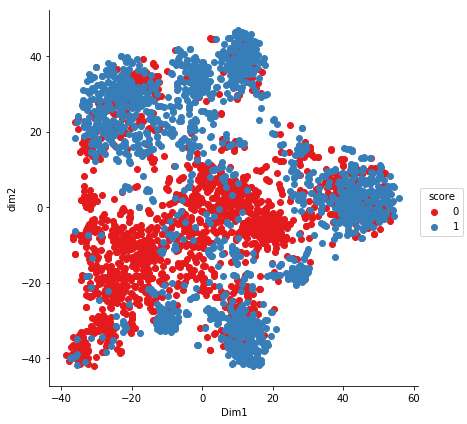

In [40]:
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(sent_vectors)
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1","dim2","score"))
sns.FacetGrid(tsne_df,hue="score",palette="Set1",hue_order=[0, 1],size=6).map(plt.scatter,'Dim1','dim2').add_legend()
plt.show()

Observation: Surely, the visualisation is better than the both methods above. Yet the points overlapping is much more.
    Cannot draw a hyperplane.

In [41]:
#TFIDF WEIGHTEDMATRIX
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_final['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [42]:
tfidf_feat = model.get_feature_names() 
tfidf_sent_vectors = []; 
row=0;
for sent in tqdm(list_of_sent): 
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:07<00:00, 426.69it/s]


Applying TSNE

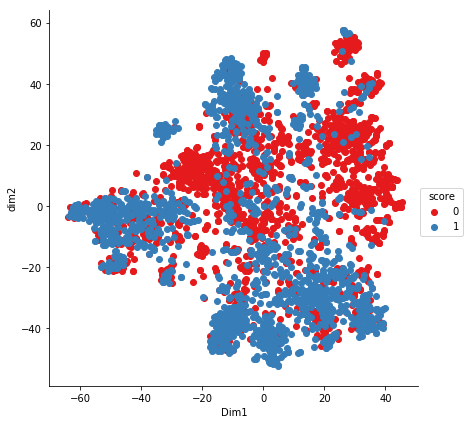

In [43]:
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(tfidf_sent_vectors)
tsne_data = np.vstack((tsne_data.T, score)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim1","dim2","score"))
sns.FacetGrid(tsne_df,hue="score",palette="Set1",hue_order=[0, 1],size=6).map(plt.scatter,'Dim1','dim2').add_legend()
plt.show()

Final Conclusions:
As we can observe, there is multiple overlapping of points in AVGW2V as well as TFIDF weighted average.
It is not possible to put a hyperplane in between positive and negative reviews and separate them.
